In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class StrongLensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            transform (callable, optional): Transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["axion", "no_sub", "cdm"]
        self.data = []

        # Load file paths and labels
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                self.data.append((file_path, class_idx))  # Store (file_path, label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        image = np.load(file_path,allow_pickle=True)  # Load .npy file
        if image.ndim!=2:
            image=image[0]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.utils.data import random_split, DataLoader


# Define transformation
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset = StrongLensingDataset("/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset", transform=transform)


# Train/Validation Split (90:10)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

class CustomMAE(nn.Module):
    def __init__(self, img_size=64, patch_size=8, embed_dim=512, num_heads=8, depth=6):
        super(CustomMAE, self).__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Patch embedding (Linear Projection + Positional Encoding)
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder (Inspired by ViT)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=1024, dropout=0.1),
            num_layers=depth
        )

        # Fully connected layer to reshape encoded features for decoding
        # self.fc = nn.Linear(embed_dim, embed_dim * (patch_size // 2) * (patch_size // 2))

        # Decoder with Up-Convolutions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Output: 64x64
        )

    def forward(self, x):
        B, C, H, W = x.shape  # Bx1x64x64
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # Convert to patches
        patches = patches + self.pos_embed  # Add positional embeddings
        
        # masked_patches = patches * mask.unsqueeze(-1)  # Apply mask

        encoded = self.encoder(patches)  # Transformer encoding
        # print(encoded.shape)

        # Reshape for decoder
        # encoded = self.fc(encoded)  # Fully connected to reshape embedding
        encoded = encoded.view(B, self.embed_dim, H // self.patch_size, W // self.patch_size)

        # Decode using up-convolutions
        reconstructed_img = self.decoder(encoded)

        return reconstructed_img

In [6]:
# Load Pretrained MAE
pretrained_mae = CustomMAE()  # Load pre-trained weights if available
pretrained_mae.load_state_dict(torch.load("/kaggle/input/model-weights/pytorch/default/1/models/pretrainedmae_epoch10.pth"))

<ipython-input-6-c4a857d53e29>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_mae.load_state_dict(torch.load("/kaggle/input/model-weights/pytorch/default/1/mode

<All keys matched successfully>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

class MAEClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes=3):
        super(MAEClassifier, self).__init__()

        self.encoder = pretrained_mae.patch_embed  # Use the same patch embedding
        self.pos_embed = pretrained_mae.pos_embed
        self.transformer = pretrained_mae.encoder  # Use the pre-trained transformer

        embed_dim = pretrained_mae.embed_dim
        num_patches = pretrained_mae.num_patches

        # Classification head
        self.cls_head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape  # Bx1x64x64

        # Convert image to patches
        patches = self.encoder(x).flatten(2).transpose(1, 2)  # Convert to patch embeddings
        patches = patches + self.pos_embed  # Add positional embeddings

        # Transformer encoding
        encoded = self.transformer(patches)  # B x num_patches x embed_dim

        # Global average pooling over patches
        encoded = encoded.mean(dim=1)  # B x embed_dim

        # Classification head
        logits = self.cls_head(encoded)  # B x num_classes
        return logits


In [12]:
model = MAEClassifier(pretrained_mae).to(device)
model.load_state_dict(torch.load("/kaggle/input/model-weights/pytorch/default/1/models/classifer_epoch22.pth"))

<ipython-input-12-4a8b3d0f7070>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/model-weights/pytorch/default/1/models/class

<All keys matched successfully>

Accuracy: 81.64%


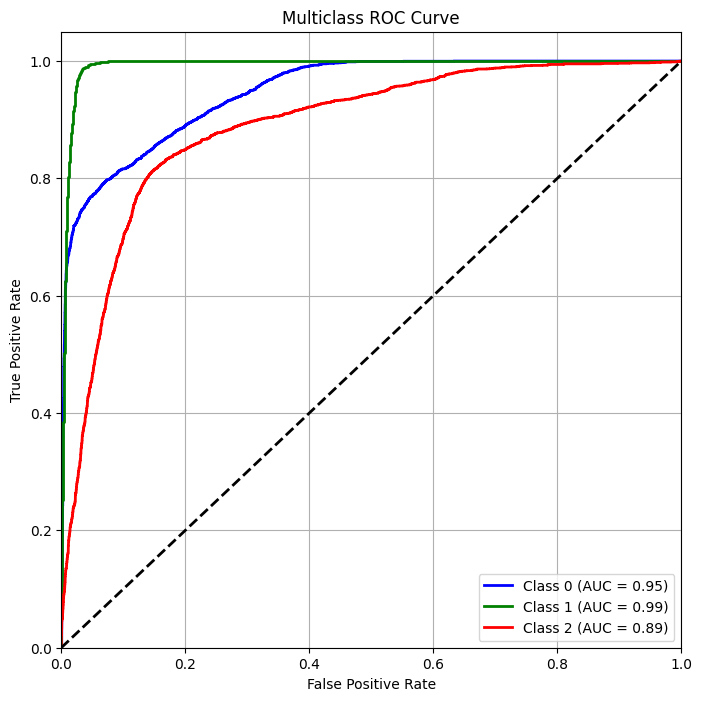

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y_true, y_scores, n_classes, title="Multiclass ROC Curve"):
    # Binarize the labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure(figsize=(8, 8))
    colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan'])

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            preds = outputs.argmax(1)    # Get predicted classes

            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_scores = np.vstack(all_preds)         # Predicted probabilities
    y_true = np.concatenate(all_labels)     # Actual labels

    # Calculate accuracy
    y_pred = np.argmax(y_scores, axis=1)    # Predicted labels from probabilities
    val_acc = val_correct / val_total

    print(f"Accuracy: {val_acc * 100:.2f}%")
    return y_true, y_scores



# Evaluate the model using validation data
y_true, y_scores = evaluate_model(model, val_loader, device)

# Determine the number of classes from predictions
n_classes = y_scores.shape[1]

# Plot the ROC curve for multiclass classification
plot_multiclass_roc(y_true, y_scores, n_classes)
